In [2]:
import os

os.listdir(r"D:\climate\data")


['weather.csv.csv']

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

weather = pd.read_csv(r"D:\climate\data\weather.csv.csv")

print(weather.head())
print(weather.columns)

           dt  AverageTemperature  AverageTemperatureUncertainty     City  \
0  1849-01-01              26.704                          1.435  Abidjan   
1  1849-02-01              27.434                          1.362  Abidjan   
2  1849-03-01              28.101                          1.612  Abidjan   
3  1849-04-01              26.140                          1.387  Abidjan   
4  1849-05-01              25.427                          1.200  Abidjan   

         Country Latitude Longitude  
0  Côte D'Ivoire    5.63N     3.23W  
1  Côte D'Ivoire    5.63N     3.23W  
2  Côte D'Ivoire    5.63N     3.23W  
3  Côte D'Ivoire    5.63N     3.23W  
4  Côte D'Ivoire    5.63N     3.23W  
Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City',
       'Country', 'Latitude', 'Longitude'],
      dtype='str')


In [4]:
# Convert date column
weather["dt"] = pd.to_datetime(weather["dt"])

# Filter Perth, Australia
perth = weather[(weather["Country"] == "Australia") & (weather["City"] == "Perth")].copy()
perth = perth.sort_values("dt").reset_index(drop=True)

print(perth[["dt", "AverageTemperature"]].head())
print("Data range:", perth["dt"].min(), "to", perth["dt"].max())


Empty DataFrame
Columns: [dt, AverageTemperature]
Index: []
Data range: NaT to NaT


In [7]:
aus_cities = sorted(weather.loc[weather["Country"]=="Australia", "City"].dropna().unique())
print("Number of Australian cities:", len(aus_cities))
print(aus_cities[:50])   # first 50


Number of Australian cities: 2
['Melbourne', 'Sydney']


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

weather["dt"] = pd.to_datetime(weather["dt"], errors="coerce")
weather = weather.dropna(subset=["dt", "AverageTemperature"])

city = "Sydney"   # change to "Melbourne" if you prefer
df = weather[(weather["Country"] == "Australia") & (weather["City"] == city)].copy()
df = df.sort_values("dt").reset_index(drop=True)

# Summer months (Dec–Mar)
df["month"] = df["dt"].dt.month
summer = df[df["month"].isin([12, 1, 2, 3])].copy()

# Heatwave threshold and 3+ consecutive days
thr = summer["AverageTemperature"].quantile(0.95)
summer["hot_day"] = summer["AverageTemperature"] >= thr

grp = (summer["hot_day"] != summer["hot_day"].shift()).cumsum()
summer["run_len"] = summer.groupby(grp)["hot_day"].transform("sum") * summer["hot_day"].astype(int)
summer["heatwave"] = summer["run_len"] >= 3

print("City:", city)
print("Date range:", df["dt"].min(), "to", df["dt"].max())
print("Heatwave threshold (95th %ile):", round(thr, 2), "°C")
print("Heatwave days:", int(summer["heatwave"].sum()))


City: Sydney
Date range: 1841-01-01 00:00:00 to 2013-08-01 00:00:00
Heatwave threshold (95th %ile): 20.83 °C
Heatwave days: 6


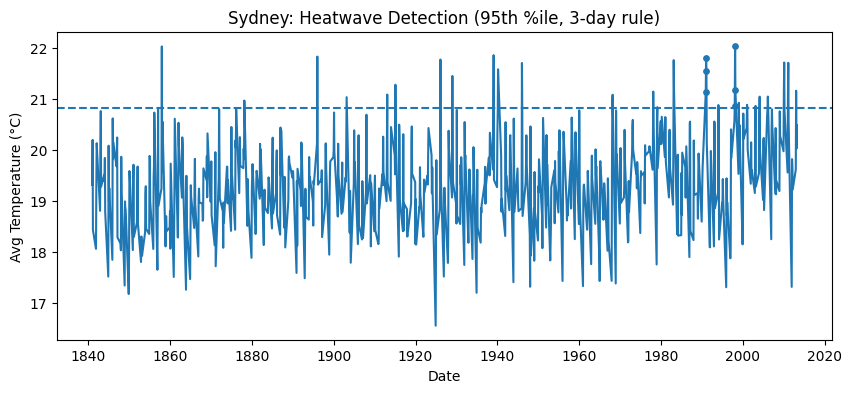

In [9]:
plt.figure(figsize=(10,4))
plt.plot(summer["dt"], summer["AverageTemperature"])
plt.axhline(thr, linestyle="--")
plt.scatter(summer.loc[summer["heatwave"], "dt"],
            summer.loc[summer["heatwave"], "AverageTemperature"], s=15)
plt.title(f"{city}: Heatwave Detection (95th %ile, 3-day rule)")
plt.xlabel("Date"); plt.ylabel("Avg Temperature (°C)")
plt.show()


In [28]:
import pandas as pd

df = pd.read_csv(r"D:\climate\data\complete_dataset.csv")
print(df.head())
print(df.columns)


         date      demand        RRP  demand_pos_RRP  RRP_positive  \
0  2015-01-01   99635.030  25.633696       97319.240     26.415953   
1  2015-01-02  129606.010  33.138988      121082.015     38.837661   
2  2015-01-03  142300.540  34.564855      142300.540     34.564855   
3  2015-01-04  104330.715  25.005560      104330.715     25.005560   
4  2015-01-05  118132.200  26.724176      118132.200     26.724176   

   demand_neg_RRP  RRP_negative  frac_at_neg_RRP  min_temperature  \
0        2315.790     -7.240000         0.020833             13.3   
1        8523.995    -47.809777         0.062500             15.4   
2           0.000      0.000000         0.000000             20.0   
3           0.000      0.000000         0.000000             16.3   
4           0.000      0.000000         0.000000             15.0   

   max_temperature  solar_exposure  rainfall school_day holiday  
0             26.9            23.6       0.0          N       Y  
1             38.8            26

In [29]:
import numpy as np

df["date"] = pd.to_datetime(df["date"])

# Heatwave threshold (top 5% hottest days)
threshold = df["max_temperature"].quantile(0.95)
df["heatwave"] = df["max_temperature"] >= threshold

print("Heatwave temperature threshold:", round(threshold,2), "°C")
print("Number of heatwave days:", df["heatwave"].sum())


Heatwave temperature threshold: 33.1 °C
Number of heatwave days: 107


In [30]:
hw = df[df["heatwave"]]
nonhw = df[~df["heatwave"]]

mean_hw = hw["demand"].mean()
mean_nonhw = nonhw["demand"].mean()

peak_hw = hw["demand"].quantile(0.99)
peak_nonhw = nonhw["demand"].quantile(0.99)

increase_mean = (mean_hw - mean_nonhw) / mean_nonhw * 100
increase_peak = (peak_hw - peak_nonhw) / peak_nonhw * 100

print("Average demand increase on heatwave days:", round(increase_mean,2), "%")
print("Peak demand increase on heatwave days:", round(increase_peak,2), "%")


Average demand increase on heatwave days: 15.42 %
Peak demand increase on heatwave days: 14.85 %


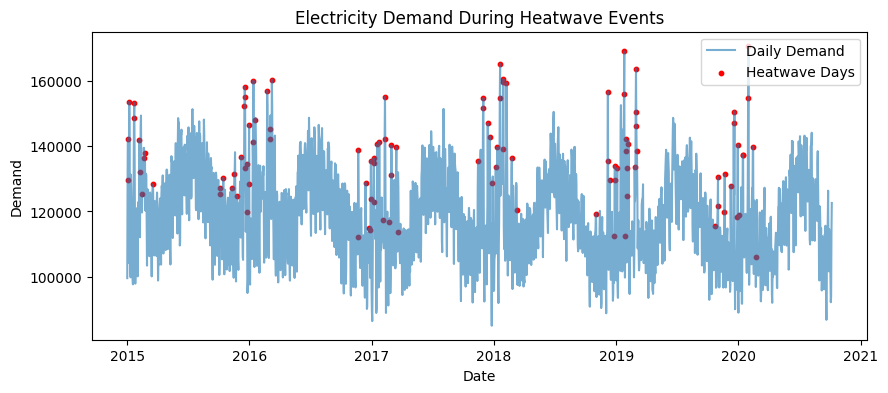

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df["date"], df["demand"], alpha=0.6, label="Daily Demand")
plt.scatter(hw["date"], hw["demand"], color="red", s=10, label="Heatwave Days")
plt.title("Electricity Demand During Heatwave Events")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()
